# Example I: Tracking data stored in files

In this example notebook we are going to track rain-rates that are estimated from radar based reflectivities. The rain-rates is an example dataset from the CPOL radar archive that used to operate north of Darwin, Australia. This example dataset has been provided by Valentin Louf from the Australian Bureau of Meteorology.

A more detailed example of the application of the tracking algorithm can be found in [doi: 10.1002/qj.4360](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.4360)

Before we get started we import all modules that are needed to apply the tracking

In [1]:
from IPython.display import HTML
from tintx import RunDirectory, config
import xarray as xr
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import cartopy.crs as crs
%matplotlib inline

In this example we want to apply the tracking algorithm only for a limited time period. Such time periods can be passed as string or `datetime` object. If defined as a string make sure they follow the [ISO 8061](https://en.wikipedia.org/wiki/ISO_8601) convention.

In [2]:
first = '2006-11-16 03:00' #Start-date
last = '2006-11-16 11:00' #End-date
data_files = Path(os.environ["DATA_FILES"])

To apply the tracking we create an instance of the `RunDirectory` class. Normally we would have to create this instance with a `xarray.DataArray`. The `from_files` method is a convenience method that allows us to create this instance without opening a dataset. The method will open the data files and create an object. We will have to provide a filename or a list of files, the name of the variable and if not according to cf conventions the names of the *longitude*, *latitude* and *time* dimensions and the used Coordinate Reference System (CRS) of the source data:

In [3]:
RD = RunDirectory.from_files( data_files / "CPOL_radar.nc", "radar_estimated_rain_rate",
                             start=first, end=last, use_cftime=True, x_coord="longitude", y_coord="latitude", crs="aeqd")

Additional keyword arguments can be added to the `xarray.open_mfdataset` method. In this example we used the `use_cftime` keyword to convert the time variable to cftime vectors.

### The tuning parameters
To apply the actual tracking algorithm we can use the `get_tracks` method. The algorithm can be tuned by passing the values for the tuning parameters. See also the [tuning parameter section](api.html#tracking-parameter-guide) of the docs.

In [4]:
print(config.__doc__)


Tracking tuning parameters
--------------------------

The following parameter can be set to tune the cell tracking algorithm

* field_thresh: units of 'field' attribute, default: 32
    The threshold used for object detection. Detected objects are connected
    pixels above this threshold.
* iso_thresh: units of 'field' attribute, default: 4
    Used in isolated cell classification. Isolated cells must not be connected
    to any other cell by contiguous pixels above this threshold.
* iso_smooth: pixels, default: 4
    Gaussian smoothing parameter in peak detection preprocessing. See
    single_max in tint.objects.
* min_size: square kilometers, default: 8
    The minimum size threshold in pixels for an object to be detected.
* search_margin: meters, default: 250
    The radius of the search box around the predicted object center.
* flow_margin: meters, default: 750
    The margin size around the object extent on which to perform phase
    correlation.
* max_disparity: float, default

Apply the tracking with a rain-rate threshold of 0.1 and a minimum size of 4. The return value of the function will be the total number of individual storms identified by the algorithm.

In [5]:
num_cells = RD.get_tracks(field_thresh=0.1, min_size=4)
print(f"Number of storm cells found: {num_cells}")

Tracking:   0%|          | 0/48 [00:00<?, ?it/s]

Number of storm cells found: 125


### Accessing the track data
The actual tracking data is stored in a multi-index [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) and can be accessed via the `tracks` property, it will be converted to [geopandas.GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) on the fly:

In [6]:
RD.tracks

time   grid_x  grid_y       lon      lat  area  \
scan uid                                                                  
0    0    2006-11-16 03:00:00    6.308  45.731  129.8469 -12.5164    26   
     1    2006-11-16 03:00:00    2.034  51.655  129.7554 -12.3810    29   
     2    2006-11-16 03:00:00  103.341  50.902  132.0804 -12.4046    41   
     3    2006-11-16 03:00:00   75.000  49.750  131.4358 -12.4288     4   
     4    2006-11-16 03:00:00   90.684  52.842  131.8040 -12.3605    19   
...                       ...      ...     ...       ...      ...   ...   
46   121  2006-11-16 10:40:00   37.000  78.630  130.5622 -11.7766    27   
     124  2006-11-16 10:40:00   30.800  79.600  130.4244 -11.7539     5   
47   123  2006-11-16 10:50:00   89.444  15.333  131.7603 -13.2150     9   
     121  2006-11-16 10:50:00   37.400  78.640  130.5622 -11.7766    25   
48   121  2006-11-16 11:00:00   36.905  79.095  130.5622 -11.7766    21   

                max      mean  isolated  \
scan uid                                  
0    0     1.451491  0.980084     False   
     1     1.398994  0.771455     False   
     2     5.279258  0.977871     False   
     3     1.249542  0.653577     False   
     4     3.560659  1.146169     False   
...             ...       ...       ...   
46   121  31.208767  7.085050      True   
     124   9.346570  2.719892      True   
47   123   0.227352  0.168942     False   
     121  14.703703  3.166035     False   
48   121  14.791470  3.332414      True   

                                                   geometry  
scan uid                                                     
0    0    POLYGON ((-130000.000 -40000.000, -125000.000 ...  
     1    POLYGON ((-140000.000 -27500.000, -135000.000 ...  
     2    POLYGON ((107500.000 -25000.000, 110000.000 -2...  
     3    POLYGON ((42500.000 -22500.000, 45000.000 -225...  
     4    POLYGON ((82500.000 -17500.000, 87500.000 -175...  
...                                                     ...  
46   121  POLYGON ((-62500.000 47500.000, -62500.000 525...  
     124  POLYGON ((-70000.000 52500.000, -70000.000 575...  
47   123  POLYGON ((77500.000 -110000.000, 82500.000 -11...  
     121  POLYGON ((-60000.000 47500.000, -60000.000 525...  
48   121  POLYGON ((-62500.000 47500.000, -62500.000 500...  

[299 rows x 10 columns]

After each tracking the `RunDirectory` class creates a so called hash of the resulting `DataFrame` and saves the 
tuning parameters for this specific tracking. The next time you call the tracking method the previous tuning parameters are noted and set automatically. This means that in the above example the `filed_thresh` and `min_size` parameters are automatically set for the next tracking.

## Displaying the results
Let's do some visualisation and create an animation of the tracks. This can be done by calling the `animate` method.

**Note:** To convert possible UTC time strings to local time we can give a time shift (`dt`) in hours. The plot styling can be fine tuned by the `plot_style` key word

In [7]:
anim = RD.animate(dt=9.5, fps=2, vmin=0.01, plot_style=dict(resolution="10m", title="Rain-rate"))

The return value is a [matplotlib FuncAnimation Object](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html). The animation can be save or displayed in a notebook:

In [8]:
HTML(anim.to_html5_video())

Animating:   0%|          | 0/48 [00:00<?, ?it/s]

It is also possible to save the animation to a file:

```python
anim.save("cpol_tracking.gif", fps=3)
```

The traces of the tracks can also be plotted using the `plot_trajectories` method:

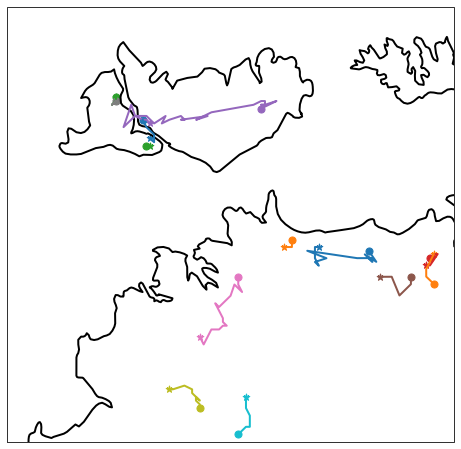

In [9]:
ax = RD.plot_trajectories(mintrace=4, plot_style=dict(lw=2))

For recent tintX versions the cell polygons are available. We can create a simple overview-plot like this:

<AxesSubplot:>

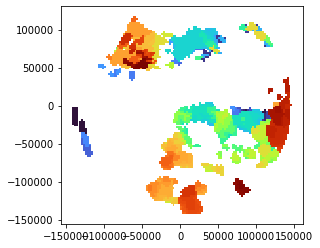

In [10]:
RD.tracks.plot(aspect=1, cmap="turbo")

Utilizing cartopy the creation of plots on a map is straightforward:

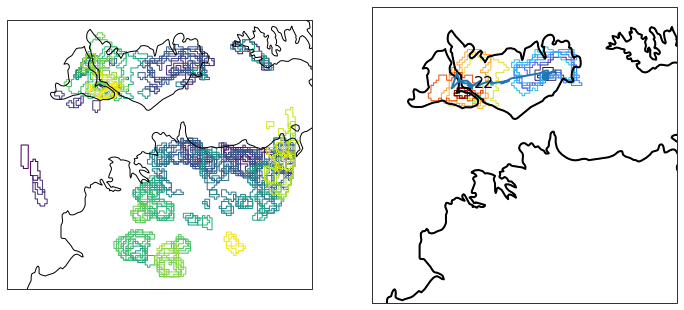

In [11]:
# NBVAL_SKIP
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(121, projection=crs.PlateCarree())

gdf = RD.tracks

# plot everything
gdf.plot(ax=ax, cmap="viridis", facecolor="None", transform=gdf.crs, aspect=1)
ax.coastlines(resolution="10m")

# plot single track
ax = fig.add_subplot(122, projection=crs.PlateCarree())
uid = "22"
gdf["geometry"][:, uid].plot(ax=ax, 
                              cmap="turbo", 
                              facecolor="None", 
                              transform=gdf.crs, 
                              aspect=1)
RD.plot_trajectories(ax=ax, mintrace=4, plot_style=dict(lw=2), uids=[uid], label=True)
ax.coastlines(resolution="10m")

## Saving the tracks for later analysis:
For a later analysis the results can be saved using the `save_tracks` method. This will save the tracks `DataFrame` to a hdf5 table format. hdf5 is the format of choice as it can save additional meta data like the tracking parameters. 

In [12]:
RD.save_tracks("/tmp/tint_tracks.h5")

## Loading the tracked files

If you have saved the tracked object with the `save_tracks` method you can create an instance of the `RunDirectory` object using the `from_dataframe` method. This method will load the tracks `DataFrame` and also try to re-open the data files that were used to track the object.

In [13]:
RD = RunDirectory.from_dataframe("/tmp/tint_tracks.h5")
RD.data

<xarray.Dataset>
Dimensions:                    (time: 49, x: 117, y: 117)
Coordinates:
  * time                       (time) datetime64[ns] 2006-11-16T03:00:00 ... ...
  * x                          (x) int32 -145000 -142500 ... 142500 145000
  * y                          (y) int32 -145000 -142500 ... 142500 145000
Data variables:
    radar_estimated_rain_rate  (time, x, y) float64 dask.array<chunksize=(49, 117, 117), meta=np.ndarray>
    latitude                   (x, y) float64 dask.array<chunksize=(117, 117), meta=np.ndarray>
    longitude                  (x, y) float64 dask.array<chunksize=(117, 117), meta=np.ndarray>
    isfile                     (time) int32 dask.array<chunksize=(49,), meta=np.ndarray>
Attributes: (12/25)
    Conventions:         CF/Radial instrument_parameters
    version:             2017-10
    title:               CPOL product level 2
    institution:         Australia Bureau of Meteorology
    references:          If you use this dataset, please cite: 'An integrated...
    source:              UF raw files
    ...                  ...
    state:               NT
    history:             October 2017 recalibration: May 2017 recalibration
    volume_number:       0
    platform_type:       fixed
    instrument_type:     radar
    primary_axis:        axis_z

In [14]:
RD.tracks

time   grid_x  grid_y       lon      lat  area  \
scan uid                                                                  
0    0    2006-11-16 03:00:00    6.308  45.731  129.8469 -12.5164    26   
     1    2006-11-16 03:00:00    2.034  51.655  129.7554 -12.3810    29   
     2    2006-11-16 03:00:00  103.341  50.902  132.0804 -12.4046    41   
     3    2006-11-16 03:00:00   75.000  49.750  131.4358 -12.4288     4   
     4    2006-11-16 03:00:00   90.684  52.842  131.8040 -12.3605    19   
...                       ...      ...     ...       ...      ...   ...   
46   121  2006-11-16 10:40:00   37.000  78.630  130.5622 -11.7766    27   
     124  2006-11-16 10:40:00   30.800  79.600  130.4244 -11.7539     5   
47   123  2006-11-16 10:50:00   89.444  15.333  131.7603 -13.2150     9   
     121  2006-11-16 10:50:00   37.400  78.640  130.5622 -11.7766    25   
48   121  2006-11-16 11:00:00   36.905  79.095  130.5622 -11.7766    21   

                max      mean  isolated  \
scan uid                                  
0    0     1.451491  0.980084     False   
     1     1.398994  0.771455     False   
     2     5.279258  0.977871     False   
     3     1.249542  0.653577     False   
     4     3.560659  1.146169     False   
...             ...       ...       ...   
46   121  31.208767  7.085050      True   
     124   9.346570  2.719892      True   
47   123   0.227352  0.168942     False   
     121  14.703703  3.166035     False   
48   121  14.791470  3.332414      True   

                                                   geometry  
scan uid                                                     
0    0    POLYGON ((-130000.000 -40000.000, -125000.000 ...  
     1    POLYGON ((-140000.000 -27500.000, -135000.000 ...  
     2    POLYGON ((107500.000 -25000.000, 110000.000 -2...  
     3    POLYGON ((42500.000 -22500.000, 45000.000 -225...  
     4    POLYGON ((82500.000 -17500.000, 87500.000 -175...  
...                                                     ...  
46   121  POLYGON ((-62500.000 47500.000, -62500.000 525...  
     124  POLYGON ((-70000.000 52500.000, -70000.000 575...  
47   123  POLYGON ((77500.000 -110000.000, 82500.000 -11...  
     121  POLYGON ((-60000.000 47500.000, -60000.000 525...  
48   121  POLYGON ((-62500.000 47500.000, -62500.000 500...  

[299 rows x 10 columns]

## Obtaining tuning parameters from tracked objects

Sometimes it might be useful to retrieve the tuning parameters that resulted in certain object tracks. This is especially important when using the `from_dataframe` method. As previously mentioned the `RunDirectory` class keeps track of all tuning parameters that resulted in object tracks. To retrieve such tuning parameters you can use the `get_parameters` method. By default the method will look for latest track objects.

In [15]:
RD.get_parameters()

{'ISO_THRESH': 4.0,
 'FIELD_THRESH': 0.1,
 'ISO_SMOOTH': 4.0,
 'MIN_SIZE': 4.0,
 'SEARCH_MARGIN': 250.0,
 'FLOW_MARGIN': 750.0,
 'MAX_DISPARITY': 999.0,
 'MAX_FLOW_MAG': 50.0,
 'MAX_SHIFT_DISP': 15.0,
 'GS_ALT': 1500.0}

This concludes the first tutorial, in [the next one](II_Tracking_already_loaded_datasets.html) we will explore the application of the tracking algorithm to data has already been loaded.